In [88]:
%reload_ext autoreload
%autoreload 2

In [89]:
import os
import json
# Filter for LLM spans
from collections import defaultdict
from pathlib import Path
import shutil

from itertools import chain
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import json
import glob
import json
import os
from pathlib import Path
import pandas as pd
from collections import Counter, defaultdict

import ijson
from datetime import datetime, timezone
from pathlib import Path
import os

from tqdm.notebook import tqdm

import numpy as np


dataset_path = Path(os.path.abspath('')).parent / "dataset"

with open('dspy_hashes.json', 'r') as file:
    dspy_hashes = json.load(file)
with open("lm_mapping.json", "r") as file:
    lm_mapping = json.load(file)
lm_mapping_inverse = {v: k for k, v in lm_mapping.items()}


def raw_model_mapper(file_path):
    return lm_mapping.get(file_path, file_path)

# Helper functions
def get_language_model(file_path):
    if isinstance(file_path, Path):
        file_path = str(file_path)

    if not "meta_llama-3.1-70b-instruct" in file_path and not "meta_llama-3.1-405b-instruct" in file_path:
        lm = file_path.split("/")[-2].split("_")[0]
    elif "meta_llama-3.1-405b-instruct" in file_path:
        lm = "meta_llama-3.1-405b-instruct"
    else: 
        lm = "meta_llama-3.1-70b-instruct"
    # Adjust LM names to match the desired format
    return raw_model_mapper(lm)

def load_solution(solution_path):
    with open(solution_path, "r") as f:
        return json.load(f)



# Cost Estimation and Token Sums

In [90]:

def sum_tokens(lm_name):
    total_input_tokens = 0
    total_output_tokens = 0
    total_total_tokens = 0

    subset_input_tokens = 0
    subset_output_tokens = 0
    subset_total_tokens = 0

    message_count = 0

    # lm_name is the value of lm_mapping, resolve the key
    lm_name = lm_mapping_inverse.get(lm_name, lm_name)

    file_pattern = Path(os.path.join(os.path.abspath(""), "..", "dataset")) / f"*/out/{lm_name}_augmented_prompt/chat_log.jsonl"
    glob_pattern = glob.glob(file_pattern.as_posix())
    assert len(glob_pattern) > 0, f"No files found for pattern {file_pattern}"
    for filename in glob_pattern:
        with open(filename, 'r') as file:
            for line in file:
                try:
                    data = json.loads(line)
                    if "AIMessage" in data['id']:
                        if 'usage_metadata' in data['kwargs']:
                            metadata = data['kwargs']['usage_metadata']

                            add_to_input = metadata.get('input_tokens', 0) + metadata.get('prompt_token_count', 0)
                            add_to_output = metadata.get('output_tokens', 0) + metadata.get('candidates_token_count', 0)
                            add_to_total = metadata.get('total_tokens', 0) + metadata.get('total_token_count', 0)

                            total_input_tokens += add_to_input
                            total_output_tokens += add_to_output
                            total_total_tokens += add_to_total

                            if any(dspy_hash in filename for dspy_hash in dspy_hashes):
                                subset_input_tokens += add_to_input
                                subset_output_tokens += add_to_output
                                subset_total_tokens += add_to_total

                            message_count += 1

                        elif 'token_usage' in data['kwargs'].get('response_metadata', {}):
                            metadata = data['kwargs']['response_metadata']['token_usage']


                            total_input_tokens += metadata.get('prompt_tokens', 0)
                            total_output_tokens += metadata.get('completion_tokens', 0)
                            total_total_tokens += metadata.get('total_tokens', 0)

                            if any(dspy_hash in filename for dspy_hash in dspy_hashes):
                                subset_input_tokens += metadata.get('prompt_tokens', 0)
                                subset_output_tokens += metadata.get('completion_tokens', 0)
                                subset_total_tokens += metadata.get('total_tokens', 0)
                            message_count += 1
                except json.JSONDecodeError:
                    print(f"Error decoding JSON in file {filename}")

    return total_input_tokens, total_output_tokens, message_count, total_total_tokens, subset_input_tokens, subset_output_tokens, subset_total_tokens

# Use the file pattern


# input_tokens, output_tokens, message_count, total_total_tokens = sum_tokens("gemini-1.5-pro")


# print(f"Total input tokens: {input_tokens:,}")
# print(f"Total output tokens: {output_tokens:,}")
# print(f"Total tokens: {input_tokens + output_tokens:,}")

# print(f"Total total tokens: {total_total_tokens:,}")
# print(f"Total messages: {message_count:,}")

# print(f"Average input tokens per message: {input_tokens / message_count:.2f}")

# print()
# print(f"""total_input_tokens = {input_tokens}
# total_output_tokens = {output_tokens}
# num_invocations = {message_count}""")

# Summary Table total successes


In [91]:
dataset_path = Path(os.path.abspath('')).parent / "dataset"

generated_graphs_path = Path(os.path.expanduser("~/Projects/Masterthesis-paper/generated_graphs"))


def format_percentage(value, total):
    percentage = (value / total) * 100
    if percentage.is_integer():
        return f"{value} ({int(percentage)}\\%)"
    return f"{value} ({percentage:.1f}\\%)"

def split_header_for_latex(header_name: str): 
    split = header_name.split(" ")
    if len(split) == 1:
        return header_name
    return '\\begin{tabular}[c]{@{}l@{}}' + '\\\\'.join(split) + '\\end{tabular}'

# Main processing
out_path = dataset_path /"*/out"
all_commits = set(path.split("/")[-2] for path in glob.glob(out_path.as_posix()))



successes = defaultdict(lambda: {'Compilation': [], 'Test': []})
non_successes = defaultdict(lambda: {'Failures': []})

lm_attempts = defaultdict(set)



all_data = []
chatlog_path = dataset_path /"*/out/*/chat_log.jsonl"
for file in glob.glob(chatlog_path.as_posix()):
    lm = get_language_model(file)
    commit = file.split("/")[-4]
    if lm == "gemini-1.5-flash":
        continue
    lm_attempts[lm].add(commit)
    
    commit_hash = Path(file).parent.parent.parent.name
    solution_path = Path(file).parent / "solution.json"
    error_path = Path(file).parent / "error.txt"
    
    row = {
        'LM': lm,
        'Commit': commit_hash,
        'Attempts': 1,
        'Other Errors': 0,
        'Test Errors': 0,
        'Test Success': 0
    }
    
    if solution_path.exists():
        solution = load_solution(solution_path)
        if solution["compilation_has_succeeded"] and not solution["test_has_succeeded"]:
            row['Test Errors'] = 1
            successes["agent_"+lm]["Compilation"].append(commit_hash)
        if solution["test_has_succeeded"] and solution["compilation_has_succeeded"]:
            row['Test Success'] = 1
            successes["agent_"+lm]["Test"].append(commit_hash)
    
    if error_path.exists():
        row['Other Errors'] = 1
        non_successes["agent_"+lm]["Failures"].append(commit_hash)
    all_data.append(row)

df = pd.DataFrame(all_data)

# Filter for dspy_hashes
filtered_df = df[df['Commit'].isin(dspy_hashes)]

aggregation_params = {
    'Attempts': 'sum',
    'Test Success': 'sum',
    'Test Errors': 'sum',
    'Other Errors': 'sum',
}

# Aggregate data
success_df = df.groupby('LM').agg(aggregation_params).reset_index().sort_values('Test Success', ascending=False)

success_65_df = filtered_df.groupby('LM').agg(aggregation_params).reset_index().sort_values('Test Success', ascending=False)


success_df['Error Percentage'] = (success_df['Other Errors'] / success_df['Attempts']) * 100

# Calculate mean, median, and standard deviation of the error percentages
mean_error_percentage = success_df['Error Percentage'].mean()
median_error_percentage = success_df['Error Percentage'].median()
stdev_error_percentage = success_df['Error Percentage'].std()

print("Error Percentages: {:.2f}% mean, {:.2f}% median, {:.2f}% stdev".format(
    mean_error_percentage, 
    median_error_percentage, 
    stdev_error_percentage
))
success_df = success_df.drop('Error Percentage', axis=1)

columns = success_df.columns


# Prepare column names for LaTeX
latex_columns = [split_header_for_latex(col) for col in columns]
success_df.columns = latex_columns

# Generate LaTeX table
latex_table = success_df.to_latex(index=False, 
                          escape=False, 
                          column_format='lllrr',
                          caption=f"Agentic Execution with different language models (n={len(all_commits)})",
                          position="H",
                          label="tab:agentic-execution")
print()

print(latex_table)

if generated_graphs_path.exists():
    with open(generated_graphs_path / "agentic_execution_table.tex", "w") as f:
        f.write(latex_table)

print()
missing_commits = {lm: all_commits - attempts for lm, attempts in lm_attempts.items()}

# Reset column names for further processing if needed
success_df.columns = columns

success_df

Error Percentages: 88.25% mean, 93.57% median, 10.57% stdev

\begin{table}[H]
\caption{Agentic Execution with different language models (n=140)}
\label{tab:agentic-execution}
\begin{tabular}{lllrr}
\toprule
LM & Attempts & \begin{tabular}[c]{@{}l@{}}Test\\Success\end{tabular} & \begin{tabular}[c]{@{}l@{}}Test\\Errors\end{tabular} & \begin{tabular}[c]{@{}l@{}}Other\\Errors\end{tabular} \\
\midrule
claude-3.5-sonnet & 140 & 32 & 12 & 96 \\
gpt-4o & 140 & 17 & 11 & 112 \\
gpt-4o-mini & 140 & 9 & 8 & 123 \\
gemini-1.5-pro & 140 & 7 & 2 & 131 \\
Llama-3.1-70B & 140 & 6 & 2 & 132 \\
claude-3-haiku & 140 & 6 & 1 & 133 \\
mistral-nemo & 132 & 1 & 1 & 130 \\
\bottomrule
\end{tabular}
\end{table}




,LM,Attempts,Test Success,Test Errors,Other Errors
2,claude-3.5-sonnet,140,32,12,96
4,gpt-4o,140,17,11,112
5,gpt-4o-mini,140,9,8,123
3,gemini-1.5-pro,140,7,2,131
0,Llama-3.1-70B,140,6,2,132
1,claude-3-haiku,140,6,1,133
6,mistral-nemo,132,1,1,130


# Intersections between Language Models

In [92]:
from collections import defaultdict

compilation_intersections = defaultdict(set)
test_intersections = defaultdict(set)

print(successes)



# Fill the dictionaries with hash values from each agent
for agent, results in successes.items():
    print(results)
    for hash_value in results['Compilation']:
        compilation_intersections[hash_value].add(agent)
    for hash_value in results['Test']:
        test_intersections[hash_value].add(agent)

# Create a DataFrame to show intersections at the commit level with count and shortened hashes
commit_data = []

for hash_value, agents in compilation_intersections.items():
    if len(agents) > 0:
        commit_data.append({'Type': 'Compilation', 'Hash': hash_value, 'Count': len(agents)})

for hash_value, agents in test_intersections.items():
    if len(agents) > 0:
        commit_data.append({'Type': 'Test', 'Hash': hash_value, 'Count': len(agents)})

commit_df_short = pd.DataFrame(commit_data)


# Sort by count and take top 5 for each type
top_compilation = commit_df_short[commit_df_short['Type'] == 'Compilation'].nlargest(4, 'Count')
top_test = commit_df_short[commit_df_short['Type'] == 'Test'].nlargest(4, 'Count')

# Combine top entries
top_commits = pd.concat([top_compilation, top_test])

# Set multiindex
top_commits.set_index(['Type', 'Hash'], inplace=True)

# Convert DataFrame to LaTeX table with booktabs and multiindex
commit_latex_table_top = top_commits.T.to_latex(index=True, multirow=True, header=True, caption="Top 3 intersections for Compilation and Test categories", label="tab:top-intersections", position="H")

# print(commit_latex_table_top)

# top_commits
# Filter rows for Compilation and Test types
unique_compilation = commit_df_short[commit_df_short['Type'] == 'Compilation']
unique_test = commit_df_short[commit_df_short['Type'] == 'Test']

# Get the frequency of each value in the 'Count' column for Compilation
compilation_count_frequency = unique_compilation['Count'].value_counts(normalize=True).sort_index() * 100

# Get the frequency of each value in the 'Count' column for Test as a percentage
test_count_frequency = unique_test['Count'].value_counts(normalize=True).sort_index() * 100

# Combine both frequencies into a single DataFrame
combined_frequency = pd.DataFrame({
    'Compilation (%)': compilation_count_frequency,
    'Test (%)': test_count_frequency
}).fillna(0)  # Fill NaN values with 0

combined_frequency.index = combined_frequency.index - 1

combined_frequency.index.name = 'LLM-Intersections'


# Convert the DataFrame to a LaTeX table
latex_table = combined_frequency.to_latex(index=True, float_format="%.2f", caption="Frequency of Intersections between LLMs for Compilation and Test categories", label="tab:intersection-frequency", position="H")

# print(latex_table)


# print()

print(combined_frequency.T.to_latex(index=True, float_format="%.2f", caption="Frequency of Intersections between LLMs for Compilation and Test categories", label="tab:intersection-frequency", position="H"))

defaultdict(<function <lambda> at 0x74a02f5d98a0>, {'agent_gpt-4o-mini': {'Compilation': ['489aad6060454d0b7b34a144e0b345c5a3a199f5', '8502e85f9ee2ff90ce96b47b5904f011e81e8bb8', 'b6a48a6e557fad1ceda680618e0a34c7b8c5c087', 'af6e5d1cc94f031f29b4838e7a8b56704c8c5de4', 'ad80bdff62b1b0520d3fb9e8d627532a38a7c60c', '250cafc7d6ae47d5d4803b5a5e58186eb81fa3b5', 'c3818c076f0c088d1d11b7812b880be579c19ec2', '14fc5fa696f499cac48401b3a86882b3bf7d9b82'], 'Test': ['0a11c04038eae517540051dbf51f7f26b7221f20', '36859167815292f279e570d39dd2ddbcf1622dc6', '0abf7148300f40a1da0538ab060552bca4a2f1d8', 'cd5bb39f43e4570b875027073da3d4e43349ead1', '165381d26b2c3d2278fde88c16f95807506451fe', 'ff8b5b61548d50cf60b77784a181e917cb35033b', '5769bdad76925da568294cb8a40e7d4469699ac3', '6c53cd904bd66fc79af8687571e607c259226b81', '0305beafdecb0b28f7c94264ed20cdc4e41ff067']}, 'agent_claude-3.5-sonnet': {'Compilation': ['489aad6060454d0b7b34a144e0b345c5a3a199f5', '8502e85f9ee2ff90ce96b47b5904f011e81e8bb8', 'a2b0fc53611f87056

# Missing Commits per language model

In [93]:
import glob
import os
from pathlib import Path
from collections import defaultdict
import pandas as pd


# Get attempted commits for each LM


# Create a DataFrame for better visualization
df_missing = pd.DataFrame({
    'LM': list(missing_commits.keys()),
    'Missing Commits': [len(commits) for commits in missing_commits.values()],
    'Total Commits': len(all_commits),
    'Attempted Commits': [len(all_commits) - len(commits) for commits in missing_commits.values()],
})

df_missing['Percentage Missing'] = (df_missing['Missing Commits'] / df_missing['Total Commits'] * 100).round(2)
df_missing['Percentage Attempted'] = (df_missing['Attempted Commits'] / df_missing['Total Commits'] * 100).round(2)

# Sort by percentage missing in descending order
df_missing = df_missing.sort_values('Percentage Missing', ascending=False)



# Optional: Display the actual missing commit hashes for each LM
# print("\nDetailed Missing Commits by LM:")
for lm, commits in missing_commits.items():
    if commits:
        print(f"\n{lm} - Missing {len(commits)} commits:")
        print(json.dumps(list(commits), indent=2))
        # for commit in sorted(commits):
        #     print(f"  {commit}")

# Calculate overall statistics
total_attempts = sum(len(attempts) for attempts in lm_attempts.values())
unique_attempts = len(set.union(*lm_attempts.values()))
overall_missing = len(all_commits) - unique_attempts

print(f"\nOverall Statistics:")
print(f"Total Commits: {len(all_commits)}")
# print(f"Unique Attempted Commits: {unique_attempts}")
# print(f"Overall Missing Commits: {overall_missing}")
print(f"Percentage of Commits Attempted by at least one LM: {(unique_attempts / len(all_commits) * 100):.2f}%")

print("Analysis of Missing Commits by Language Model:")
df_missing


mistral-nemo - Missing 8 commits:
[
  "24d4a90ec1b375751e71f33d18949405c9529d77",
  "2dfaa41bfb97674d11f09a5885011f19808548a3",
  "54857351e0b0a655970d7e2ccdb67f175cc5d688",
  "41ec14e7e0ccf28476905eb28b2155b11d8a55f5",
  "923a6b2027e3ca1762deb6a60fc0a768c284122b",
  "867e69e208ff59d1f8baae7ed41d3e163a51bc65",
  "cb541fd65c7b9bbc3424ea927f1dab223261d156",
  "5769bdad76925da568294cb8a40e7d4469699ac3"
]

Overall Statistics:
Total Commits: 140
Percentage of Commits Attempted by at least one LM: 100.00%
Analysis of Missing Commits by Language Model:


,LM,Missing Commits,Total Commits,Attempted Commits,Percentage Missing,Percentage Attempted
4,mistral-nemo,8,140,132,5.71,94.29
1,gpt-4o-mini,0,140,140,0.00,100.00
0,claude-3-haiku,0,140,140,0.00,100.00
2,Llama-3.1-70B,0,140,140,0.00,100.00
3,claude-3.5-sonnet,0,140,140,0.00,100.00
5,gemini-1.5-pro,0,140,140,0.00,100.00
6,gpt-4o,0,140,140,0.00,100.00


# Correlation of Performance to Berkeley Function Calling Leaderboard
```
@misc{berkeley-function-calling-leaderboard,
    title={Berkeley Function Calling Leaderboard}, 
    author={Fanjia Yan and Huanzhi Mao and Charlie Cheng-Jie Ji
    and Tianjun Zhang and Shishir G. Patil and Ion Stoica and Joseph E.
    Gonzalez},
    howpublished={\url{https://gorilla.cs.berkeley.edu/blogs/8_berkeley_function_calling_leaderboard.html}},
    year={2024},
}
```

Version used: 2024-07-28

In [94]:
url = 'https://raw.githubusercontent.com/ShishirPatil/gorilla/gh-pages/data_live.csv'

function_calling_leaderboard = pd.read_csv(url)


# discard all models that have (prompt) in their name
function_calling_leaderboard = function_calling_leaderboard[~function_calling_leaderboard['Model'].str.contains("(Prompt)")]

# get all columns that contain either a number with a percent sign, a number or NaN

def is_numeric_or_percent(s):
    if pd.api.types.is_numeric_dtype(s):
        return True
    elif pd.api.types.is_object_dtype(s):
        try:
            # Try to convert to numeric, treating '%' as a special case
            return pd.to_numeric(s.astype(str).str.rstrip('%'), errors='coerce').notna().any()
        except AttributeError:
            # If we can't use .str accessor, it's not a string column
            return False
    else:
        return False

numeric_percent_nan_cols = function_calling_leaderboard.columns[
    function_calling_leaderboard.apply(lambda col: is_numeric_or_percent(col) or col.isna().any())
]

# filter out Rankm Cost, Latency columns
relevant_cols = numeric_percent_nan_cols[~numeric_percent_nan_cols.str.contains("Rank|Cost|Latency")]


function_calling_leaderboard

/tmp/ipykernel_690398/2028199607.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  function_calling_leaderboard = function_calling_leaderboard[~function_calling_leaderboard['Model'].str.contains("(Prompt)")]


,Rank,Overall Acc,Model,Model Link,Organization,License,AST Summary,Python Simple AST,Python Multiple AST,Python Parallel AST,Python Parallel Multiple AST,Irrelevance Detection,Relevance Detection,Cost ($ Per 1k Function Calls),Latency Mean (s),Latency Standard Deviation (s),Latency 95th Percentile (s)
0,1,74.54%,GPT-4-0613 (FC),https://platform.openai.com/docs/models/gpt-4-...,OpenAI,Proprietary,73.26%,66.67%,77.72%,0.00%,0.00%,76.57%,73.17%,15.36,2.46,2.84,6.40
3,4,73.39%,GPT-4-turbo-2024-04-09 (FC),https://platform.openai.com/docs/models/gpt-4-...,OpenAI,Proprietary,72.96%,67.83%,74.45%,75.00%,62.50%,74.17%,70.73%,6.24,2.85,3.33,8.76
6,7,71.79%,GPT-4o-2024-08-06 (FC),https://openai.com/index/hello-gpt-4o/,OpenAI,Proprietary,69.14%,67.83%,69.43%,75.00%,66.67%,76.23%,63.41%,1.62,1.02,0.94,2.69
7,8,71.70%,Gemini-1.5-Pro-Preview-0409 (FC),https://deepmind.google/technologies/gemini/#i...,Google,Proprietary,67.42%,62.40%,68.85%,81.25%,50.00%,78.63%,63.41%,1.49,1.91,1.07,3.62
9,10,71.39%,Claude-3.5-Sonnet-20240620 (FC),https://www.anthropic.com/news/claude-3-5-sonnet,Anthropic,Proprietary,71.09%,72.48%,70.68%,68.75%,75.00%,72.23%,63.41%,5.31,3.11,1.16,5.30
10,11,71.26%,Functionary-Medium-v3.1 (FC),https://huggingface.co/meetkai/functionary-med...,MeetKai,MIT,77.15%,72.09%,78.69%,68.75%,70.83%,62.29%,70.73%,NaN,5.06,5.45,13.35
11,12,71.12%,Gemini-1.5-Pro-Preview-0514 (FC),https://deepmind.google/technologies/gemini/pro/,Google,Proprietary,66.82%,61.63%,68.27%,81.25%,50.00%,78.29%,58.54%,1.49,2.03,1.14,3.96
13,14,70.99%,GPT-4-0125-Preview (FC),https://platform.openai.com/docs/models/gpt-4-...,OpenAI,Proprietary,74.38%,69.77%,75.89%,68.75%,62.50%,65.14%,85.37%,6.49,3.37,4.00,12.05
14,15,70.81%,Gemini-1.5-Flash-Preview-0514 (FC),https://deepmind.google/technologies/gemini/fl...,Google,Proprietary,70.34%,64.34%,72.52%,56.25%,50.00%,71.89%,63.41%,0.13,0.77,0.34,1.19
15,16,70.50%,Claude-3-Opus-20240229 (FC tools-2024-04-04),https://www.anthropic.com/news/claude-3-family,Anthropic,Proprietary,68.09%,64.73%,70.40%,43.75%,20.83%,74.06%,73.17%,37.72,12.05,4.07,19.30


/tmp/ipykernel_690398/2746134888.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  function_calling_leaderboard['LM'] = function_calling_leaderboard['Model'].apply(lambda x: correlation_with_df.get(x, x))


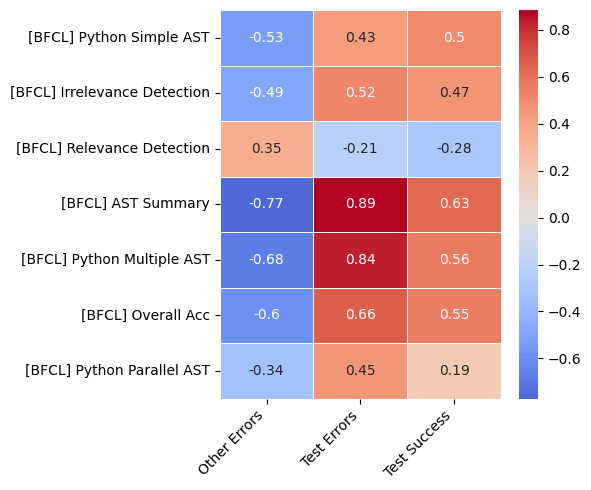

,Other Errors,Test Errors,Test Success
[BFCL] Python Simple AST,-0.534404,0.428754,0.504786
[BFCL] Irrelevance Detection,-0.487553,0.522474,0.469418
[BFCL] Relevance Detection,0.349609,-0.209742,-0.283967
[BFCL] AST Summary,-0.772036,0.885236,0.630211
[BFCL] Python Multiple AST,-0.683107,0.837526,0.560922
[BFCL] Overall Acc,-0.598612,0.661539,0.550183
[BFCL] Python Parallel AST,-0.335354,0.451071,0.185546


In [95]:


correlation_with_df = {
  "Claude-3.5-Sonnet-20240620 (FC)": "claude-3.5-sonnet",
  "Gemini-1.5-Pro-Preview-0514 (FC)": "gemini-1.5-pro",
#   "Gemini-1.5-Flash-Preview-0514 (FC)": "gemini-1.5-flash",
  "GPT-4o-mini-2024-07-18 (FC)": "gpt-4o-mini",
  "Open-Mistral-Nemo-2407 (FC Auto)": "mistral-nemo",
  "GPT-4o-2024-05-13 (FC)": "gpt-4o",
  "Claude-3-Haiku-20240307 (FC tools-2024-04-04)": "claude-3-haiku"
}

# pick the models that are in the correlation
function_calling_leaderboard = function_calling_leaderboard[function_calling_leaderboard['Model'].isin(list(correlation_with_df.keys()))]

# rename model names
function_calling_leaderboard['LM'] = function_calling_leaderboard['Model'].apply(lambda x: correlation_with_df.get(x, x))

leaderboard_relevant = function_calling_leaderboard[list(relevant_cols) + ['LM']]
success_relevant = success_df[['LM', 'Other Errors', 'Test Errors', 'Test Success']]




# Merge dataframes on the 'LM' column
merged_df = pd.merge(leaderboard_relevant, success_relevant, on='LM')

# Convert percentages to numerical values
for col in relevant_cols:
    merged_df[col] = merged_df[col].str.rstrip('%').astype(float)

# Convert 'Errors' column to numeric
# merged_df['Errors'] = pd.to_numeric(merged_df['Errors'].str.extract(r'(\d+)')[0])

# rename every column but LM to include [BFCL] as prefix
merged_df = merged_df.rename(columns={col: f"[BFCL] {col}" for col in relevant_cols if col != 'LM'})


# Calculate the correlation matrix
updated_correlation_matrix = merged_df.corr(numeric_only=True)

# Function to get the highest and lowest correlations for a target column
def get_top_bottom_corr(corr_matrix, target_col, num=3):
    corr_series = corr_matrix[target_col].drop(target_col)
    highest_corr = corr_series.nlargest(num).index.tolist()
    lowest_corr = corr_series.nsmallest(num).index.tolist()
    return highest_corr + lowest_corr

# Get top and bottom correlations for Errors, Compile Success, and Test Success
top_bottom_errors = get_top_bottom_corr(updated_correlation_matrix, 'Other Errors')
top_bottom_compile_success = get_top_bottom_corr(updated_correlation_matrix, 'Test Errors')
top_bottom_test_success = get_top_bottom_corr(updated_correlation_matrix, 'Test Success')

# Combine all selected columns with Overall Acc

# get the column from updated_correlation_matrix that resembles Overall Acc
overall_acc = [col for col in updated_correlation_matrix.columns.tolist() if 'Overall Acc' in col]

java_ast = [col for col in updated_correlation_matrix.columns.tolist() if 'Java ' in col]

selected_columns = list(set(overall_acc + java_ast + top_bottom_errors + top_bottom_compile_success + top_bottom_test_success ))
selected_columns = [col for col in selected_columns if col not in ['Other Errors', 'Test Errors', 'Test Success']]

selected_correlations = updated_correlation_matrix.loc[selected_columns, ['Other Errors', 'Test Errors', 'Test Success']]

# Plot the correlation heatmap with better labeling
plt.figure(figsize=(6, 5))
sns.heatmap(selected_correlations, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
# plt.title('Correlation Heatmap between Berkeley Function Calling Leaderboard and Success Metrics')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Add labels to the side of the heatmap for clarity
for ytick, ylabel in zip(plt.gca().get_yticks(), plt.gca().get_yticklabels()):
    ylabel.set_rotation(0)
    ylabel.set_horizontalalignment('right')

plt.tight_layout()

if generated_graphs_path.exists():
    plt.savefig(generated_graphs_path / "bfcl_correlation_heatmap_agent.pdf", bbox_inches='tight')
plt.show()
selected_correlations


In [96]:
bfcl_correlations_latex = selected_correlations.copy()

# make metric a col
bfcl_correlations_latex = bfcl_correlations_latex.reset_index()
bfcl_correlations_latex = bfcl_correlations_latex.rename(columns={'index': 'Metric'})
bfcl_correlations_latex['Metric'] = bfcl_correlations_latex['Metric'].str.replace('[BFCL] ', '')



# Replace column names
bfcl_correlations_latex = bfcl_correlations_latex.rename(columns={'Compile Success': '\\begin{mlhead}Compile \\\\Success\\end{mlhead}',
                                   'Test Success': '\\begin{mlhead}Test \\\\Success\\end{mlhead}'})

print(bfcl_correlations_latex.to_latex(index=False, escape=False, position="H", caption="Correlation Heatmap between Berkeley Function Calling Leaderboard and Success Metrics", label="tab:bfcl-correlation-agent", float_format="%.3f"))

\begin{table}[H]
\caption{Correlation Heatmap between Berkeley Function Calling Leaderboard and Success Metrics}
\label{tab:bfcl-correlation-agent}
\begin{tabular}{lrrr}
\toprule
Metric & Other Errors & Test Errors & \begin{mlhead}Test \\Success\end{mlhead} \\
\midrule
Python Simple AST & -0.534 & 0.429 & 0.505 \\
Irrelevance Detection & -0.488 & 0.522 & 0.469 \\
Relevance Detection & 0.350 & -0.210 & -0.284 \\
AST Summary & -0.772 & 0.885 & 0.630 \\
Python Multiple AST & -0.683 & 0.838 & 0.561 \\
Overall Acc & -0.599 & 0.662 & 0.550 \\
Python Parallel AST & -0.335 & 0.451 & 0.186 \\
\bottomrule
\end{tabular}
\end{table}



# Diff Analysis per Language Model

In [97]:
from collections import defaultdict

dataset_path = Path(os.path.abspath('')).parent / "dataset"


diffs = defaultdict(dict)
for file in dataset_path.glob("*/out/*/solution.json"):
    lm = get_language_model(file)
    file = str(file)
    commit = file.split("/")[-4]
    final_diff_path = Path(file).parent / "final_state.diff"
    if final_diff_path.exists():
        with open(final_diff_path, "r") as f:
            diff = f.read()
            if commit not in diffs[lm]:
              diffs[lm][commit] = set()
            diffs[lm][commit].add(diff)




from unidiff import LINE_TYPE_ADDED, LINE_TYPE_REMOVED, PatchSet

from masterthesis.agent.aider.AdvancedDiffAgent import UnifiedDiffCoder

# Function to calculate diff statistics
def calculate_diff_stats(diff, commit):

    patch = PatchSet(diff)

    
    operation_count = sum([file_patch.added+file_patch.removed for file_patch in patch])
    hunk_count = sum([len(file_patch) for file_patch in patch])

    return {
        'files_modified': len(patch),  
        'operation_count': operation_count,
        'hunk_count': hunk_count
    } 

# Transform diffs and add statistics
transformed_diffs = defaultdict(lambda: defaultdict(list))
for lm, commits in diffs.items():
    for commit, diff_set in commits.items():
        for diff in diff_set:
            stats = calculate_diff_stats(diff, commit)
            transformed_diffs[lm][commit].append({
                'diff': diff,
                'files_modified': stats['files_modified'],
                'operation_count': stats['operation_count'],
                'hunk_count': stats['hunk_count']
            })

# Create a DataFrame
rows = []
for lm, commits in transformed_diffs.items():
    for commit, diffs in commits.items():
        for diff_data in diffs:
            rows.append({
                'language_model': lm,
                'commit': commit,
                'files_modified': diff_data['files_modified'],
                'operation_count': diff_data['operation_count'],
                'hunk_count': diff_data['hunk_count']
            })

diff_df = pd.DataFrame(rows)





In [98]:
# diff_df_prepared = diff_df[diff_df['commit'].isin(dspy_hashes)]
diff_df_prepared = diff_df.copy()

# Commit-level statistics
commit_stats = diff_df_prepared.groupby(['language_model', 'commit']).agg({
    'files_modified': ['mean', 'median', 'std'],
    'operation_count': ['mean', 'median', 'std'],
    'hunk_count': ['mean', 'median', 'std']
}).reset_index()

len_of_commit = len(commit_stats['commit'].unique())

print(f"Commit-level statistics for {len_of_commit} commits:")




# Language model comparison
lm_comparison = diff_df_prepared.groupby('language_model').agg({
    'files_modified': ['mean', 'median', 'std'],
    'operation_count': ['mean', 'median', 'std'],
    'hunk_count': ['mean', 'median', 'std']
}).reset_index()

# diff_df.to_pickle("diff_stats.pkl")

lm_comparison

Commit-level statistics for 52 commits:


language_model files_modified                  operation_count         \
                               mean median       std            mean median   
0      Llama-3.1-70B       1.000000    1.0  0.000000        2.875000    2.0   
1     claude-3-haiku       1.000000    1.0  0.000000       13.000000    2.0   
2  claude-3.5-sonnet       1.750000    1.0  2.136341       13.295455   10.0   
3     gemini-1.5-pro       1.000000    1.0  0.000000        2.777778    2.0   
4             gpt-4o       1.035714    1.0  0.188982        7.428571    6.5   
5        gpt-4o-mini       1.071429    1.0  0.267261        7.785714    9.5   
6       mistral-nemo       1.000000    1.0  0.000000        2.000000    2.0   

             hunk_count                   
         std       mean median       std  
0   1.807722   1.125000    1.0  0.353553  
1  29.103264   1.000000    1.0  0.000000  
2  17.190559   2.545455    2.0  2.347235  
3   1.301708   1.000000    1.0  0.000000  
4   6.669047   1.321429    1.0  0.722832  
5   5.220943   1.214286    1.0  0.578934  
6   0.000000   1.000000    1.0  0.000000

In [99]:


lm_comparison_human = lm_comparison.rename(columns={'files_modified': 'Files Modified', 'operation_count': 'Operation Count', 'language_model': "Language Model"})

# print(lm_comparison_human)

def convert_float_to_int(value):
    # if isinstance(value, float):
    #     print(value, value.is_integer())
    if isinstance(value, float) and value.is_integer():
        return str(int(value))
    return value
# lm_comparison_human = lm_comparison_human.map(convert_float_to_int)



def format_mean_std_median(mean, std, median):
    if np.isnan(mean) or np.isnan(std) or np.isnan(median):
        return "N/A"
    
    if mean.is_integer():
        mean_str = str(int(mean))
    else:
        mean_str = f"{mean:.2f}"
    mean_std = f"{mean_str} ± {std:.2f}"
    if mean.is_integer() and std == 0:
        mean_std = f"{int(mean)}"
    if median.is_integer():
        median_str = str(int(median))
    else:
        median_str = f"{median:.2f}"
    return f"{mean_std} ({median_str})"

# Create a new DataFrame for the formatted data
formatted_data = []

for lm, row in lm_comparison.iterrows():
    formatted_row = {
        'Language Model': row["language_model"].to_string().strip(),
        'Files Modified': format_mean_std_median(row['files_modified']['mean'], row['files_modified']['std'], row['files_modified']['median']),
        'Operation Count': format_mean_std_median(row['operation_count']['mean'], row['operation_count']['std'], row['operation_count']['median']),
        'Hunk Count': format_mean_std_median(row['hunk_count']['mean'], row['hunk_count']['std'], row['hunk_count']['median'])
    }
    formatted_data.append(formatted_row)

formatted_df = pd.DataFrame(formatted_data)


latex_text = formatted_df.to_latex(index=False, escape=False, float_format="%.2f", position="H", caption=f"Diff Statistics by Language Model (n={len_of_commit})", label="tab:diff-stats")
                                          # , column_format="lrrr|rrr")
latex_text = latex_text.replace("±", "$\pm$")
print(latex_text)
# custom_header = [
#     ('Language Model', ''),
#     ('Files Modified', 'mean'), ('Files Modified', 'median'), ('Files Modified', 'std'),
#     ('Operation Count', 'mean'), ('Operation Count', 'median'), ('Operation Count', 'std'),
#     ('Hunk Count', 'mean'), ('Hunk Count', 'median'), ('Hunk Count', 'std')
# ]


# # latex_text = latex_text.replace("\\multicolumn{3}{r}{Files Modified}", "\\multicolumn{3}{r|}{Files Modified}")
# # print(latex_text)

# from tabulate import tabulate
# latex_table=tabulate(lm_comparison_human, tablefmt="latex_booktabs",headers=custom_header, showindex=False, floatfmt=".2f")
# latex_table = latex_table.replace("Language Model &", "\\multicolumn{1}{c}{Language Model} &")
# latex_table = latex_table.replace("Files Modified & Files Modified & Files Modified", "\\multicolumn{3}{c}{Files Modified}")
# latex_table = latex_table.replace("Operation Count & Operation Count & Operation Count", "\\multicolumn{3}{c}{Operation Count}")
# latex_table = latex_table.replace("Hunk Count & Hunk Count & Hunk Count", "\\multicolumn{3}{c}{Hunk Count}")
# latex_table = f"\\begin{{table}}[H]\n\\caption{{Diff Statistics by Language Model}}\n\\label{{tab:diff-stats}}\n{latex_table}\n\\end{{table}}"
# print(latex_table)

\begin{table}[H]
\caption{Diff Statistics by Language Model (n=52)}
\label{tab:diff-stats}
\begin{tabular}{llll}
\toprule
Language Model & Files Modified & Operation Count & Hunk Count \\
\midrule
Llama-3.1-70B & 1 (1) & 2.88 $\pm$ 1.81 (2) & 1.12 $\pm$ 0.35 (1) \\
claude-3-haiku & 1 (1) & 13 $\pm$ 29.10 (2) & 1 (1) \\
claude-3.5-sonnet & 1.75 $\pm$ 2.14 (1) & 13.30 $\pm$ 17.19 (10) & 2.55 $\pm$ 2.35 (2) \\
gemini-1.5-pro & 1 (1) & 2.78 $\pm$ 1.30 (2) & 1 (1) \\
gpt-4o & 1.04 $\pm$ 0.19 (1) & 7.43 $\pm$ 6.67 (6.50) & 1.32 $\pm$ 0.72 (1) \\
gpt-4o-mini & 1.07 $\pm$ 0.27 (1) & 7.79 $\pm$ 5.22 (9.50) & 1.21 $\pm$ 0.58 (1) \\
mistral-nemo & 1 (1) & 2 (2) & 1 (1) \\
\bottomrule
\end{tabular}
\end{table}



<>:49: SyntaxWarning: invalid escape sequence '\p'
<>:49: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_690398/2994451253.py:49: SyntaxWarning: invalid escape sequence '\p'
  latex_text = latex_text.replace("±", "$\pm$")


In [100]:

# Renaming columns to match for merging
renamed_diff_df = diff_df.rename(columns={'language_model': 'LM', 'files_modified': 'Diff Files Modified', 'operation_count': 'Diff Operation Count', 'hunk_count': 'Diff Hunk Count'})

success_df_copy = success_df.copy()
# success_df_copy['Errors'] = pd.to_numeric(success_df_copy['Errors'].str.extract(r'(\d+)')[0])
success_relevant = success_df_copy[['LM', 'Other Errors', 'Test Errors', 'Test Success']]


# Merge the datasets on the language model
merged_data_new = pd.merge(renamed_diff_df, success_relevant, on='LM')


# Calculate the correlation matrix with renamed columns
# correlation_matrix_renamed = merged_data_new[['Files Modified', 'Hunk Count', 'Compile Success', 'Test Success', 'Errors']].corr()

correlation_matrix_renamed = merged_data_new.corr(numeric_only=True)

# selected_columns


selected_correlations = correlation_matrix_renamed.loc[['Diff Files Modified', 'Diff Operation Count', 'Diff Hunk Count'], ['Other Errors', 'Test Errors', 'Test Success']]


selected_correlations

,Other Errors,Test Errors,Test Success
Diff Files Modified,-0.228356,0.164682,0.240381
Diff Operation Count,-0.221971,0.176184,0.231639
Diff Hunk Count,-0.378988,0.291783,0.392730


In [101]:
diff_correlations_latex = selected_correlations.copy()

# make metric a col
diff_correlations_latex = diff_correlations_latex.reset_index()
diff_correlations_latex = diff_correlations_latex.rename(columns={'index': 'Diff Metric'})
diff_correlations_latex['Diff Metric'] = diff_correlations_latex['Diff Metric'].str.replace('Diff ', '')



# Replace column names
diff_correlations_latex = diff_correlations_latex.rename(columns={'Compile Success': '\\begin{mlhead}Compile \\\\Success\\end{mlhead}',
                                   'Test Success': '\\begin{mlhead}Test \\\\Success\\end{mlhead}'})

print(diff_correlations_latex.to_latex(index=False, escape=False, position="H", caption="Correlation Heatmap between Diff Metrics and Success Metrics", label="tab:diff-correlation-agent", float_format="%.3f"))

\begin{table}[H]
\caption{Correlation Heatmap between Diff Metrics and Success Metrics}
\label{tab:diff-correlation-agent}
\begin{tabular}{lrrr}
\toprule
Diff Metric & Other Errors & Test Errors & \begin{mlhead}Test \\Success\end{mlhead} \\
\midrule
Files Modified & -0.228 & 0.165 & 0.240 \\
Operation Count & -0.222 & 0.176 & 0.232 \\
Hunk Count & -0.379 & 0.292 & 0.393 \\
\bottomrule
\end{tabular}
\end{table}



In [102]:
import os
import glob
from collections import defaultdict
from langchain.schema import HumanMessage
from langchain.load import loads

chat_logs = dataset_path.glob('./*/out/*_prompt/chat_log.jsonl')


# Build dictionary of first HumanMessage from each chat log
message_to_commit = {}
commit_to_message = defaultdict(set)

for chat_log_path in chat_logs:
    commit = chat_log_path.parts[-4]  # Assuming the commit is 4 levels up from the chat_log.jsonl file
    lm = chat_log_path.parts[-2]
    # print(commit)
    with open(chat_log_path, 'r') as f:
        file_text = f.read()
        for line in file_text.split('\n'):
            msg = loads(line)
            if isinstance(msg, HumanMessage):
                content = msg.content
                composite_key = commit+'_'+lm
                commit_to_message[composite_key].add(content)
                message_to_commit[content] = commit
                break


In [103]:
def process_trace_file(file_path, message_to_commit):
    trace_to_commit = {}
    lm = file_path.replace('../trace_langchain_', '').replace('_augmented_prompt.json', '')
    print(lm)

    with open(file_path, 'rb') as f:
        parser = ijson.parse(f, multiple_values=True)
        current_trace_id = None
        current_content = None
        
        for prefix, event, value in parser:
            if prefix.endswith('trace_id'):
                current_trace_id = value
            elif prefix.endswith('attributes.llm.input_messages.1.message.content'):
                current_content = value
            
            if current_trace_id and current_content:
                if current_content in message_to_commit:
                    commit = message_to_commit[current_content]
                    if commit in dspy_hashes:
                        trace_to_commit[current_trace_id] = message_to_commit[current_content]
                current_trace_id = None
                current_content = None
    
    return trace_to_commit,lm

# Main processing logic
dataset_path = Path('dataset')

trace_files = glob.glob('../trace_*.json')
trace_to_commit = defaultdict(dict)

flat_trace_to_commit = defaultdict(str)

for trace_file in tqdm(trace_files, desc="Processing trace files"):
    trace, lm = process_trace_file(trace_file, message_to_commit)
    trace_to_commit[lm] = trace
    for key, value in trace.items():
        flat_trace_to_commit[key] = value


Processing trace files:   0%|          | 0/7 [00:00<?, ?it/s]

gemini-1.5-pro-001
gpt-4o-mini
claude-3-haiku@20240307
claude-3-5-sonnet@20240620
meta_llama-3.1-70b-instruct
gpt-4o
open-mistral-nemo


In [104]:
with open("trace_to_commit.json", "w") as f:
    json.dump(trace_to_commit, f, indent=2)

with open("message_to_commit.json", "w") as f:
    json.dump(message_to_commit, f, indent=2)

len(trace_to_commit["gemini-1.5-pro-001"])

traces_filtered = flat_trace_to_commit




# Total Time for Execution and Unified Token Counting

In [105]:


from datetime import timedelta


def process_large_jsonl(file_path, language_model_id):
    print(f"Processing file: {file_path} for language model: {language_model_id}")
    
    trace_data = {}
    total_input_token_count, total_output_token_count, message_count, _, subset_input_token_count, subset_output_token_count, _ = sum_tokens(language_model_id)
    
    with open(file_path, 'rb') as file:
        parser = ijson.parse(file, multiple_values=True)
        current_trace_id = None
        current_span_kind = None
        current_start = None
        current_end = None
        
        for prefix, event, value in parser:
            if prefix.endswith('.trace_id') and event == 'string':

                if current_trace_id :
                    # Save data for the previous trace
                    trace_data[current_trace_id] = {
                        'start_time': current_start,
                        'end_time': current_end,
                        'input_tokens': current_input_tokens,
                        'output_tokens': current_output_tokens
                    }
                # Reset for new trace
                current_trace_id = value
                current_start = None
                current_end = None
                current_input_tokens = 0
                current_output_tokens = 0
            
            if prefix.endswith('attributes.openinference.span.kind') and event == 'string':
                current_span_kind = value
            
            if prefix.endswith('start_time') and event == 'string':
                current_start = datetime.fromisoformat(value.rstrip('Z')).replace(tzinfo=timezone.utc)
            
            elif prefix.endswith('end_time') and event == 'string':
                current_end = datetime.fromisoformat(value.rstrip('Z')).replace(tzinfo=timezone.utc)

            # target_date = datetime(2024,8,17, tzinfo=timezone.utc)
            # if current_end and current_end.date() == target_date.date() and 'nemo' in file_path:
            #     current_end = None
            # if current_start and current_start.date() == target_date.date() and 'nemo' in file_path:
            #     current_start = None

    
    # Save data for the last trace
    if current_trace_id:
        trace_data[current_trace_id] = {
            'start_time': current_start,
            'end_time': current_end,
            'input_tokens': current_input_tokens,
            'output_tokens': current_output_tokens
        }

    assert len(trace_data) > 0, "No valid trace data found in the file."
    
    # Calculate overall metrics
    min_start_time = min(data['start_time'] for data in trace_data.values() if data['start_time'])
    max_end_time = max(data['end_time'] for data in trace_data.values() if data['end_time'])
    overall_duration = max_end_time - min_start_time if min_start_time and max_end_time else None

    trace_data_subset = {k: v for k, v in trace_data.items() if k in traces_filtered}
    subset_start_times = [data['start_time'] for data in trace_data_subset.values() if data['start_time']]
    subset_end_times = [data['end_time'] for data in trace_data_subset.values() if data['end_time']]
    subset_min_start_time = min(subset_start_times) if subset_start_times else None
    subset_max_end_time = max(subset_end_times) if subset_end_times else None
    subset_duration = sum((data['end_time'] - data['start_time'] for data in trace_data_subset.values() if data['start_time'] and data['end_time']), timedelta())
    
    return {
        'overall_metrics': {
            'min_start_time': min_start_time,
            'max_end_time': max_end_time,
            'duration': overall_duration,
            'total_input_token_count': total_input_token_count,
            'total_output_token_count': total_output_token_count
        },
        'trace_metrics': {
            'min_start_time': subset_min_start_time,
            'max_end_time': subset_max_end_time,
            'duration': subset_duration,
            'total_input_token_count': subset_input_token_count,
            'total_output_token_count': subset_output_token_count
        }
    }



# glob *_augmented_prompt.json  
glob_paths = glob.glob(os.path.join(os.path.abspath(""), "..", "trace_langchain_*_augmented_prompt.json"))

duration_by_language_model = defaultdict(dict)
subset_duration_by_language_model = defaultdict(dict)

for file_path in tqdm(glob_paths):
    language_model_id = Path(file_path).parts[-1].replace("trace_langchain_", "").replace("_augmented_prompt.json", "")

    # Usage
    metrics = process_large_jsonl(file_path, language_model_id)

    print(metrics)
    overall_metrics, trace_metrics = metrics['overall_metrics'], metrics['trace_metrics']

    min_start_time = overall_metrics['min_start_time']
    max_end_time = overall_metrics['max_end_time']
    overall_duration = overall_metrics['duration']
    total_input_token_count = overall_metrics['total_input_token_count']
    total_output_token_count = overall_metrics['total_output_token_count']

    subset_min_start_time = trace_metrics['min_start_time']
    subset_max_end_time = trace_metrics['max_end_time']
    subset_duration = trace_metrics['duration']
    subset_input_token_count = trace_metrics['total_input_token_count']
    subset_output_token_count = trace_metrics['total_output_token_count']

    duration_by_language_model[language_model_id] = {"duration": overall_duration, "total_input_token_count": total_input_token_count, "total_output_token_count": total_output_token_count}
    subset_duration_by_language_model[language_model_id] = {"duration": subset_duration, "total_input_token_count": subset_input_token_count, "total_output_token_count": subset_output_token_count}

    if min_start_time and max_end_time:
        print(f"Minimum start time: {min_start_time.isoformat()}")
        print(f"Maximum end time: {max_end_time.isoformat()}")
        print(f"Total duration: {overall_duration}")
        print(f"Total input token count: {total_input_token_count}")
        print(f"Total output token count: {total_output_token_count}")

        print("-"*20, "Subset", "-"*20)
        print(f"Minimum start time: {subset_min_start_time.isoformat()}")
        print(f"Maximum end time: {subset_max_end_time.isoformat()}")
        print(f"Subset duration: {subset_duration}")
        print(f"Subset input token count: {subset_input_token_count}")
        print(f"Subset output token count: {subset_output_token_count}")
        print()

    else:
        print("No valid time entries found in the file.")




  0%|          | 0/7 [00:00<?, ?it/s]

Processing file: /root/thesis/masterthesis-implementation-gpt/analysis/../trace_langchain_gemini-1.5-pro-001_augmented_prompt.json for language model: gemini-1.5-pro-001
{'overall_metrics': {'min_start_time': datetime.datetime(2024, 8, 3, 12, 5, 10, 403077, tzinfo=datetime.timezone.utc), 'max_end_time': datetime.datetime(2024, 8, 4, 3, 16, 17, 78041, tzinfo=datetime.timezone.utc), 'duration': datetime.timedelta(seconds=54666, microseconds=674964), 'total_input_token_count': 13539104, 'total_output_token_count': 539635}, 'trace_metrics': {'min_start_time': datetime.datetime(2024, 8, 3, 12, 5, 10, 403077, tzinfo=datetime.timezone.utc), 'max_end_time': datetime.datetime(2024, 8, 4, 3, 16, 17, 78041, tzinfo=datetime.timezone.utc), 'duration': datetime.timedelta(seconds=13350, microseconds=174242), 'total_input_token_count': 5060767, 'total_output_token_count': 183225}}
Minimum start time: 2024-08-03T12:05:10.403077+00:00
Maximum end time: 2024-08-04T03:16:17.078041+00:00
Total duration: 15

In [106]:

import pandas as pd
import matplotlib.pyplot as plt

# Transpose and create DataFrame
df = pd.DataFrame(duration_by_language_model).T

# Convert columns to datetime
# df['min_start'] = pd.to_datetime(df['min_start'])
# df['max_end'] = pd.to_datetime(df['max_end'])

# Give Index the name "LM"
df.index.name = "LM"

# Create a new DataFrame for subset duration
subset_df = pd.DataFrame(subset_duration_by_language_model).T

# Rename columns in subset_df to include "Agent65"
subset_df.columns = [f"Agent65 {col}" for col in subset_df.columns]

# Merge the two DataFrames
df = df.merge(subset_df, left_index=True, right_index=True, how='left')

print(df)

df['total_tokens'] = df['total_input_token_count'] + df['total_output_token_count']
df['Agent65 total_tokens'] = df['Agent65 total_input_token_count'] + df['Agent65 total_output_token_count']

with open('model_prices.json', 'r') as f:
    prices = json.load(f)


def calculate_cost(row, overwrite_tries=None):
    if isinstance(row.name, int):
         model = raw_model_mapper(row["LM"])
    else:
        model = raw_model_mapper(row.name)

    print('-'*50)
    print(model)
    if "Input Tokens DSPY" in row:
        input_tokens = row['Input Tokens DSPY'] / 1_000_000
        output_tokens = row['Output Tokens DSPY'] / 1_000_000
        print("DSPY")
    elif "Agent65 total_tokens" in row:
        input_tokens = row['Agent65 total_input_token_count'] / 1_000_000
        output_tokens = row['Agent65 total_output_token_count'] / 1_000_000
        print("Agent65")
    else:
        input_tokens = row['total_input_token_count'] / 1_000_000 
        output_tokens = row['total_output_token_count']/ 1_000_000
        print("Agent")
    input_cost = 0
    output_cost = 0

    
    if 'combined' in prices[model]:
        combined_cost = prices[model]['combined']
        input_cost = input_tokens * combined_cost
        output_cost = output_tokens * combined_cost
    else:
        if 'gemini' in model:
            if 'Input Tokens Short DSPY' in row and row.get('Output Tokens Short DSPY', 0) > 0:
                input_tokens_short = row['Input Tokens Short DSPY'] / 1_000_000
                output_tokens_short = row['Output Tokens Short DSPY'] / 1_000_000
                input_tokens_long = row['Input Tokens Long DSPY'] / 1_000_000
                output_tokens_long = row['Output Tokens Long DSPY'] / 1_000_000

                input_cost = input_tokens_short * prices[model]["input_short"]
                input_cost += input_tokens_long * prices[model]["input_long"]
                output_cost = output_tokens * prices[model]["output_short"]
                output_cost += output_tokens_long * prices[model]["output_long"]
            else:
                input_cost = input_tokens * prices[model]["input_short"]
                output_cost = output_tokens * prices[model]["output_short"]

        elif 'input' in prices[model]:
            print("input in prices")
            input_cost = input_tokens * prices[model]['input']
            output_cost = output_tokens * prices[model]['output']


    total_cost = input_cost + output_cost
    
    # Look up the number of attempts from success_df

    attempts = -1
    if isinstance(overwrite_tries, int) and overwrite_tries > 0:
        attempts = overwrite_tries
    elif row["Attempts"] > 0:
        attempts = row["Attempts"]

    
    # Calculate cost per attempt
    cost_per_attempt = total_cost / attempts if attempts > 0 else 0

    print(total_cost, row["Attempts"], cost_per_attempt)
    
    return cost_per_attempt



df.index = df.index.map(raw_model_mapper)

# df['LM'] = df.index.map(raw_model_mapper)

df = df.merge(success_df[['LM', 'Attempts']], on='LM', how='left')

print(df)

df['cost_per_attempt'] = df.apply(lambda row: calculate_cost(row), axis=1, result_type="expand")
df['Agent65 cost_per_attempt'] = df.apply(lambda row: calculate_cost(row, 65), axis=1, result_type="expand")


# Calculate duration and add new column
df['duration'] = pd.to_timedelta(df['duration'])
df['duration_secs'] = df['duration'].dt.total_seconds()
df['duration_hours'] = df['duration'].dt.total_seconds() / 3600

# df['Agent65 duration'] = df['Agent65 max_end'] - df['Agent65 min_start']
df['Agent65 duration'] = pd.to_timedelta(df['Agent65 duration'])
df['Agent65 duration_secs'] = df['Agent65 duration'].dt.total_seconds()
df['Agent65 duration_hours'] = df['Agent65 duration'].dt.total_seconds() / 3600

# replace index by get_language_model
df.index = df.index.map(raw_model_mapper)


# Move index into a column "LM"
df.reset_index(inplace=True)

# add decimal places sep to total_tokens
df['total_tokens'] = df['total_tokens'].apply(lambda x: f"{x:,}")
df['Agent65 total_tokens'] = df['Agent65 total_tokens'].apply(lambda x: f"{x:,}")


final_df = df[['LM', 'duration_hours', 'total_tokens', 'cost_per_attempt', 'Agent65 duration_hours', 'Agent65 total_tokens', 'Agent65 cost_per_attempt']].rename(columns={
    'duration_hours': 'Agent Time (h)', 
    'total_tokens': 'Agent Token Sum', 
    'cost_per_attempt': "Agent Avg. Cost /Try",
    'Agent65 cost_per_attempt': "Agent65 Avg. Cost /Try",
    'Agent65 duration_hours': 'Agent65 Time (h)',
    'Agent65 total_tokens': 'Agent65 Token Sum'
})


# # LaTex Table with LM and duration_hours
# latex_table = final_df.to_latex(
#     index=False,
#     float_format="%.2f", 
#     caption="Duration of Augmented Prompt Execution by Language Model", 
#     label="tab:augmented-prompt-duration", 
#     position="H"
# )

# print(latex_table)

final_df

                                    duration total_input_token_count  \
LM                                                                     
gemini-1.5-pro-001           15:11:06.674964                13539104   
gpt-4o-mini                  21:06:26.935836                30544504   
claude-3-haiku@20240307       7:48:08.484194                24644288   
claude-3-5-sonnet@20240620   22:28:33.407574                41357473   
meta_llama-3.1-70b-instruct   7:51:30.752271                21204060   
gpt-4o                       23:50:48.125197                28343858   
open-mistral-nemo             9:04:14.375476                13652980   

                            total_output_token_count Agent65 duration  \
LM                                                                      
gemini-1.5-pro-001                            539635   3:42:30.174242   
gpt-4o-mini                                   768981   3:35:43.323159   
claude-3-haiku@20240307                      1340665   2:06

,LM,Agent Time (h),Agent Token Sum,Agent Avg. Cost /Try,Agent65 Time (h),Agent65 Token Sum,Agent65 Avg. Cost /Try
0,gemini-1.5-pro,15.185187,"14,078,739",0.140261,3.708382,"5,243,992",0.302101
1,gpt-4o-mini,21.107482,"31,313,485",0.012908,3.595368,"11,263,828",0.027802
2,claude-3-haiku,7.802357,"25,984,953",0.025852,2.104084,"12,052,785",0.055682
3,claude-3.5-sonnet,22.475947,"42,333,131",0.393217,4.186894,"16,760,202",0.846929
4,Llama-3.1-70B,7.858542,"21,607,747",0.066760,2.550373,"10,620,967",0.143792
5,gpt-4o,23.846701,"28,879,599",0.466172,4.772467,"12,670,959",1.004062
6,mistral-nemo,9.070660,"13,949,463",0.015868,1.595588,"6,981,803",0.032224


In [107]:
with open("dspy_data.json", "r") as f:
    dspy_data = json.load(f)

dspy_df = pd.DataFrame(dspy_data)


# dspy_df['DSPY Total Tokens'] = (dspy_df['Input Tokens DSPY'] + dspy_df['Output Tokens DSPY']).astype(int)
dspy_df['DSPY Avg. Cost /Try'] = dspy_df.apply(lambda row: calculate_cost(row), axis=1, result_type="expand")


dspy_df = dspy_df.merge(final_df, on="LM", how="outer")

with open("model_metadata.json", "r") as f:
    model_metadata = json.load(f)

# add release date for each model
model_metadata_df = pd.DataFrame(model_metadata["models"])
model_metadata_df["LM"] = model_metadata_df["name"]
model_metadata_df.drop(columns=["name"], inplace=True)

dspy_df = dspy_df.merge(model_metadata_df, on="LM", how="outer")
# move to second column and rename to Release Date
dspy_df.rename(columns={"releaseDate": "Release Date", "DSPY Total Tokens": "DSPY Token Sum", "DSPY Test Success": "DSPY Fixed", "DSPY Duration (hours)": "DSPY Time (h)"}, inplace=True)

cols = list(dspy_df.columns)
cols.insert(1, cols.pop(cols.index("Release Date")))
dspy_df = dspy_df[cols]


dspy_df



--------------------------------------------------
claude-3.5-sonnet
DSPY
input in prices
128.780343 65 1.981236046153846
--------------------------------------------------
gemini-1.5-pro
DSPY
614.065739 65 9.447165215384615
--------------------------------------------------
gpt-4o
DSPY
input in prices
165.437345 65 2.545189923076923
--------------------------------------------------
claude-3-haiku
DSPY
input in prices
9.313432 65 0.14328356923076924
--------------------------------------------------
mistral-nemo
DSPY
input in prices
8.2222221 65 0.1264957246153846
--------------------------------------------------
gpt-4o-mini
DSPY
input in prices
4.110495449999999 65 0.06323839153846153
--------------------------------------------------
Llama-3.1-70B
DSPY
8.99868288 65 0.13844127507692308


,LM,Release Date,Attempts,DSPY Time (h),DSPY Token Sum,DSPY Compile Success,DSPY Fixed,DSPY Errors,Input Tokens DSPY,Output Tokens DSPY,...,Output Tokens Short DSPY,Input Tokens Long DSPY,Output Tokens Long DSPY,DSPY Avg. Cost /Try,Agent Time (h),Agent Token Sum,Agent Avg. Cost /Try,Agent65 Time (h),Agent65 Token Sum,Agent65 Avg. Cost /Try
0,Llama-3.1-70B,2024-06-23,65,2.108296,10225776,7,4,54,10116424,109352,...,0.0,0.0,0.0,0.138441,7.858542,"21,607,747",0.066760,2.550373,"10,620,967",0.143792
1,claude-3-haiku,2024-03-19,65,13.108757,33342196,22,7,36,32364313,977883,...,0.0,0.0,0.0,0.143284,7.802357,"25,984,953",0.025852,2.104084,"12,052,785",0.055682
2,claude-3.5-sonnet,2024-06-20,65,12.623933,39102221,28,12,25,38146081,956140,...,0.0,0.0,0.0,1.981236,22.475947,"42,333,131",0.393217,4.186894,"16,760,202",0.846929
3,gemini-1.5-pro,2024-05-24,65,16.812150,120935424,24,10,31,119489811,1445613,...,1361327.0,51114988.0,84286.0,9.447165,15.185187,"14,078,739",0.140261,3.708382,"5,243,992",0.302101
4,gpt-4o,2024-05-13,65,17.444548,31855785,26,8,30,31239943,615842,...,0.0,0.0,0.0,2.545190,23.846701,"28,879,599",0.466172,4.772467,"12,670,959",1.004062
5,gpt-4o-mini,2024-06-18,65,12.653006,22533745,11,4,50,20910559,1623186,...,0.0,0.0,0.0,0.063238,21.107482,"31,313,485",0.012908,3.595368,"11,263,828",0.027802
6,mistral-nemo,2024-06-18,65,5.011655,27407407,14,3,48,26502242,905165,...,0.0,0.0,0.0,0.126496,9.070660,"13,949,463",0.015868,1.595588,"6,981,803",0.032224


In [108]:
agent_65_columns = {
    "Compile Success": "Agent65 Test Errors",
    "Errors": "Agent65 General Errors",
    "Test Success": "Agent65 Fixed", 
    "Attempts": "Agent65 Attempts",
    "Other Errors": "Agent65 General Errors",
    "Test Errors": "Agent65 Test Errors",
}

success_65_df_pre_merge = success_65_df.rename(columns=agent_65_columns)

correlation_df_final = dspy_df.merge(success_df, on="LM", how="outer")

correlation_df_final = correlation_df_final.merge(success_65_df_pre_merge, on="LM", how="outer")

In [114]:



# I need correlation between DSPY Fixed and DSPY Avg. Cost /Try
# I need the correlation for Test Success and Agent Avg. Cost /Try
# I need it for Agent65 Test Success and Agent65 Avg. Cost /Try

# Assuming correlation_df_final is your DataFrame
from scipy.stats import pearsonr

def get_correlation(col1, col2):
    r, p = pearsonr(correlation_df_final[col1], correlation_df_final[col2])
    print(f"Correlation between {col1} and {col2}: r = {r:.3}, p = {p:.4}")


print('-'*20, "Cost", '-'*20)
get_correlation('DSPY Fixed', 'DSPY Avg. Cost /Try')
get_correlation('Test Success', 'Agent Avg. Cost /Try')
get_correlation('Agent65 Fixed', 'Agent65 Avg. Cost /Try')

print('-'*20, "Time", '-'*20)

get_correlation('DSPY Fixed', 'DSPY Time (h)')
get_correlation('Test Success', 'Agent Time (h)')
get_correlation('Agent65 Fixed', 'Agent65 Time (h)')





-------------------- Cost --------------------
Correlation between DSPY Fixed and DSPY Avg. Cost /Try: r = 0.602, p = 0.1529
Correlation between Test Success and Agent Avg. Cost /Try: r = 0.816, p = 0.02507
Correlation between Agent65 Fixed and Agent65 Avg. Cost /Try: r = 0.845, p = 0.01666
-------------------- Time --------------------
Correlation between DSPY Fixed and DSPY Time (h): r = 0.667, p = 0.1017
Correlation between Test Success and Agent Time (h): r = 0.734, p = 0.06061
Correlation between Agent65 Fixed and Agent65 Time (h): r = 0.885, p = 0.008103


In [110]:
import string
import pandas as pd
import numpy as np
import re

# Assuming dspy_df and success_df are already defined as per your input

def format_number(x, round_to_millions=False, add_usd_sign=False):
    if isinstance(x, pd.Series):
        return x.apply(lambda val: format_single_number(val, round_to_millions, add_usd_sign))
    else:
        return format_single_number(x, round_to_millions, add_usd_sign)

def format_single_number(x, round_to_millions=False, add_usd_sign=False):
    if pd.isna(x) or x == 'nan' or x == '-' or x == '' or x is None:
        return '-'
    
    try:
        num = float(str(x).replace(',', ''))
        
        if round_to_millions:
            millions = round(num / 1_000_000, 1)
            if millions == 0:
                return '-'
            if millions.is_integer():
                return f'{int(millions)}M'
            return f'{millions:.0f}M'
        
        if np.isclose(num, round(num)):
            return f'{int(round(num)):,}'
        
        if add_usd_sign:
            return f'${num:.2f}'
        return f'{num:.1f}'
    except ValueError:
        return '-'


def safe_percentage_to_float(x):
    if pd.isna(x) or x == '-':
        return 0.0
    return float(x.rstrip('%')) / 100 if isinstance(x, str) else x

def change(x):
    if isinstance(x, float):
        return x
    return float(x.split(" ")[0])



merged_df = dspy_df.merge(success_df, on="LM", how="outer")



agent_columns = {
    "Compile Success": "Agent Test Errors",
    "Errors": "Agent General Errors",
    "Test Success": "Agent Fixed",
    "Attempts": "Agent Attempts",
    "Test Errors": "Agent Test Errors",
    "Other Errors": "Agent General Errors",
}


print(success_65_df_pre_merge.columns)
merged_df = merged_df.merge(success_65_df_pre_merge, on="LM", how="outer")

merged_df['Sum of Success'] = (
    merged_df['Test Success'].fillna(0).astype(int) +
    merged_df['Agent65 Fixed'].fillna(0).astype(int) +
    merged_df['DSPY Fixed'].fillna(0).astype(int)
)

# Sort by Sum of Success
merged_df = merged_df.sort_values('Sum of Success', ascending=False)
merged_df = merged_df.drop('Sum of Success', axis=1)

general_renames = {
    'DSPY Compile Success': 'DSPY Test Errors',
    "DSPY Errors": "DSPY General Errors",
}

# Combine all renaming dictionaries
all_renames = {**general_renames, **agent_columns}
# Rename columns
merged_df.rename(columns=all_renames, inplace=True)

# merged_df.drop(columns=['Compile Success'], inplace=True)

print(merged_df.columns)


# Apply the formatting
for col in merged_df.columns:
    if col != 'LM':
        if 'Token Sum' in col:
            merged_df[col] = merged_df[col].apply(lambda x: format_number(x, round_to_millions=True))
        elif 'Success' in col:
            merged_df[col] = merged_df[col].apply(lambda x: x if not pd.isna(x) else '-')
        elif 'Avg. Cost /Try' in col:
            merged_df[col] = merged_df[col].apply(lambda x: format_number(x, add_usd_sign=True))
        elif 'Date' in col:
            pass
        else:
            merged_df[col] = merged_df[col].apply(lambda x: format_number(x))


def format_errors(test_errors, general_errors):
    test = '-' if pd.isna(test_errors) else str(int(test_errors))
    general = '-' if pd.isna(general_errors) else str(int(general_errors))
    return f"{test}, {general}"

error_suffix = 'Errors (Test, Other)'

for prefix in ['DSPY', 'Agent65', 'Agent']:
    merged_df[f'{prefix} {error_suffix}'] = merged_df.apply(
        lambda row: format_errors(row[f'{prefix} Test Errors'], row[f'{prefix} General Errors']), 
        axis=1
    )
    merged_df = merged_df.drop(columns=[f'{prefix} Test Errors', f'{prefix} General Errors'])


def custom_sort_key(col_name):
    order = ['Fixed', error_suffix, 'Time (h)', 'Token Sum', 'Avg. Cost /Try']
    try:
        return order.index(col_name)
    except ValueError:
        return len(order)

# Reorder columns
forbidden_words = ['Attempts']

dspy_columns = [col for col in merged_df.columns if col.startswith('DSPY') and not any(word in col for word in forbidden_words)]
agent_65_columns = [col for col in merged_df.columns if col.startswith('Agent65') and not any(word in col for word in forbidden_words)]
agent_columns = [col for col in merged_df.columns if col.startswith('Agent') and col not in agent_65_columns and not any(word in col for word in forbidden_words)]
dspy_columns = sorted(dspy_columns, key=lambda x: custom_sort_key(x.replace('DSPY ', '')))
agent_65_columns = sorted(agent_65_columns, key=lambda x: custom_sort_key(x.replace('Agent65 ', '')))
agent_columns = sorted(agent_columns, key=lambda x: custom_sort_key(x.replace('Agent ', '')))


merged_df.drop('Release Date', axis=1, inplace=True)

metadata_columns = ['LM']

column_order = metadata_columns + dspy_columns + agent_65_columns + agent_columns

dspy_len = len(dspy_columns)-2
agent_65_len = len(agent_65_columns)-2
agent_len = len(agent_columns)-2

columns_format = 'l' * len(metadata_columns) + '|' + 'lr' + 'c' * dspy_len + '|' + 'lr' + 'c' * agent_65_len + '|' +'lr'+ 'c' * agent_len

merged_df = merged_df[column_order]

column_tuples = (
    [('Metadata', col) for col in metadata_columns] +
    [('Zero-Shot (n=65)', col) for col in dspy_columns] +
    [('Agent (n=65)', col) for col in agent_65_columns] +
    [('Agent (n=140)', col) for col in agent_columns]
)
print(column_tuples)
merged_df.columns = pd.MultiIndex.from_tuples(column_tuples)

# Rename columns to remove prefixes
merged_df = merged_df.rename(columns=lambda x: x.replace('DSPY ', '').replace('Agent ', '').replace('Agent65', '') if x not in metadata_columns else x, level=1)

# merged_df.drop(columns=['Errors'], inplace=True)



# Generate LaTeX table
latex_table = merged_df.to_latex(
    index=False,
    multicolumn=True,
    multicolumn_format='c',
    column_format=columns_format,
    escape=True,
    bold_rows=True,
    # caption='Comparison of Language Models for DSPY and Agent Tasks',

    # label='tab:lm-comparison',
    # position='H'
)

# latex_table = latex_table.replace('\\begin{table}[H]', '\\begin{table*}')
# latex_table = latex_table.replace('\\end{table}', '\\end{table*}')

for col in merged_df.columns.get_level_values(1):
    if ' ' in col:
        latex_table = latex_table.replace(col, '\\begin{mlhead}' + col.replace(' ', ' \\\\ ') + '\\end{mlhead}')

footnotes = {
    # "claude-3.5-sonnet": "Due to budgetary limitations, this model could not be executed for DSPY",
    # "gemini-1.5-pro": "Due to budgetary limitations, this model could not be executed for DSPY",
    "NeMo": "The models used are claude-3.5-sonnet and claude-3-haiku, mistral-nemo, llama-3.1-70B and gemini-1.5-pro respectively, with the full names omitted for brevity"
    # "Llama-3.1-70B": "Together.ai, which we use for Llama inference supports tool use via a custom setup, which was not supported by Langchain at the time of writing."
}

latex_table = latex_table.replace('claude-3.5-sonnet', 'Sonnet 3.5').replace('gemini-1.5-pro', 'Gemini Pro').replace('mistral-nemo', 'NeMo').replace('Llama-3.1-70B', 'Llama 3.1').replace('gpt-4o-mini', 'GPT4o mini').replace('claude-3-haiku', 'Haiku 3')

# Extract model names from latex_table
model_names = re.findall(r'^(\S+)\s+&', latex_table, re.MULTILINE)


# Create an ordered list of unique footnote texts
ordered_footnote_texts = []
for model in model_names:
    if model in footnotes and footnotes[model] not in ordered_footnote_texts:
        ordered_footnote_texts.append(footnotes[model])

# Create a mapping of footnote texts to footnote numbers
footnote_numbering = {text: i for i, text in enumerate(ordered_footnote_texts, 1)}

# Generate mapping for footnotes
mapping = dict(zip(range(1, len(ordered_footnote_texts) + 1), string.ascii_lowercase))

# Apply footnotes to the table content
for model in model_names:
    if model in footnotes:
        footnote_num = footnote_numbering[footnotes[model]]
        latex_table = latex_table.replace(
            f"{model} &",
            f"{model} \\textsuperscript{{{mapping[footnote_num]}}} &",
            1  # Replace only the first occurrence to maintain order
        )

# Generate footnote text
footnote_text = "\n".join(
    f"\\footnotetext[{footnote_numbering[text]}]{{{text}}}"
    for text in ordered_footnote_texts
)

latex_table = f"""
\\begin{{table*}}
\\caption{{Comparison of Language Models using the Zero-Shot and Agentic Approach}}
\\label{{tab:lm-comparison}}
\\begin{{minipage}}{{\\textwidth}}
\\begin{{center}}
{latex_table}
{footnote_text}
\\end{{center}}
\\end{{minipage}}
\\end{{table*}}
"""

if generated_graphs_path.exists():
    with open(generated_graphs_path / "lm_comparison_approach_table.tex", "w") as f:
        f.write(latex_table)

print(latex_table)
merged_df

Index(['LM', 'Agent65 Attempts', 'Agent65 Fixed', 'Agent65 Test Errors',
       'Agent65 General Errors'],
      dtype='object')
Index(['LM', 'Release Date', 'Attempts_x', 'DSPY Time (h)', 'DSPY Token Sum',
       'DSPY Test Errors', 'DSPY Fixed', 'DSPY General Errors',
       'Input Tokens DSPY', 'Output Tokens DSPY', 'Input Tokens Short DSPY',
       'Output Tokens Short DSPY', 'Input Tokens Long DSPY',
       'Output Tokens Long DSPY', 'DSPY Avg. Cost /Try', 'Agent Time (h)',
       'Agent Token Sum', 'Agent Avg. Cost /Try', 'Agent65 Time (h)',
       'Agent65 Token Sum', 'Agent65 Avg. Cost /Try', 'Attempts_y',
       'Agent Fixed', 'Agent Test Errors', 'Agent General Errors',
       'Agent65 Attempts', 'Agent65 Fixed', 'Agent65 Test Errors',
       'Agent65 General Errors'],
      dtype='object')
[('Metadata', 'LM'), ('Zero-Shot (n=65)', 'DSPY Fixed'), ('Zero-Shot (n=65)', 'DSPY Errors (Test, Other)'), ('Zero-Shot (n=65)', 'DSPY Time (h)'), ('Zero-Shot (n=65)', 'DSPY Token Sum'), (

Metadata Zero-Shot (n=65)                                          \
                  LM            Fixed Errors (Test, Other) Time (h) Token Sum   
2  claude-3.5-sonnet               12               28, 25     12.6       39M   
4             gpt-4o                8               26, 30     17.4       32M   
3     gemini-1.5-pro               10               24, 31     16.8      121M   
5        gpt-4o-mini                4               11, 50     12.7       22M   
1     claude-3-haiku                7               22, 36     13.1       33M   
0      Llama-3.1-70B                4                7, 54      2.1       10M   
6       mistral-nemo                3               14, 48      5.0       27M   

                 Agent (n=65)                                             \
  Avg. Cost /Try        Fixed  Errors (Test, Other)  Time (h)  Token Sum   
2          $1.98           12                10, 43       4.2        17M   
4          $2.55            9                 9, 47       4.8        13M   
3          $9.45            4                 0, 61       3.7         5M   
5          $0.06            6                 7, 52       3.6        11M   
1          $0.14            2                 0, 63       2.1        12M   
0          $0.14            2                 1, 62       2.6        11M   
6          $0.13            0                 1, 63       1.6         7M   

                  Agent (n=140)                                          \
   Avg. Cost /Try         Fixed Errors (Test, Other) Time (h) Token Sum   
2           $0.85            32               12, 96     22.5       42M   
4           $1.00            17              11, 112     23.8       29M   
3           $0.30             7               2, 131     15.2       14M   
5           $0.03             9               8, 123     21.1       31M   
1           $0.06             6               1, 133      7.8       26M   
0           $0.14             6               2, 132      7.9       22M   
6           $0.03             1               1, 130      9.1       14M   

                  
  Avg. Cost /Try  
2          $0.39  
4          $0.47  
3          $0.14  
5          $0.01  
1          $0.03  
0          $0.07  
6          $0.02

# Github Dependency Popularity

In [111]:
import os
import json
import requests
from collections import defaultdict

from dotenv import load_dotenv
load_dotenv(".env") 

# Cache to store stargazer counts
stargazers_cache = {}

# Function to get stargazers count using GitHub GraphQL API with caching
def get_stargazers_count(repo_slug):
    if repo_slug in stargazers_cache:
        return stargazers_cache[repo_slug]

    github_token = os.getenv('GITHUB_TOKEN')
    headers = {
        'Authorization': f'Bearer {github_token}',
        'Content-Type': 'application/json'
    }

    if "/" not in repo_slug:
        return -1
    
    owner, name = repo_slug.split('/')
    
    query = """
    query($owner: String!, $name: String!) {
      repository(owner: $owner, name: $name) {
        stargazerCount
      }
    }
    """
    
    variables = {
        'owner': owner,
        'name': name
    }
    
    response = requests.post(
        'https://api.github.com/graphql',
        json={'query': query, 'variables': variables},
        headers=headers
    )
    
    if response.status_code == 200:
        result = response.json()
        stargazer_count = result['data']['repository']['stargazerCount']
        stargazers_cache[repo_slug] = stargazer_count
        return stargazer_count
    else:
        print(f"Failed to fetch data for {repo_slug}: {response.json()}")
        return -1

# Function to load JSON data for a given commit
def load_json_data(commit):
    file_path = Path(os.path.abspath("")) / "bump" / "data" / "benchmark" / f"{commit}.json"
    with open(file_path, 'r') as file:
        return json.load(file)





In [112]:
# Clone successes structure for storing stargazers counts
stargazers = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
dependency_slugs = set()

combined_results = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

# Process successes
for agent, categories in successes.items():
    for category, commits in categories.items():
        for commit in commits:
            combined_results[agent][category]['Successes'].append(commit)

# Process non_successes
for agent, categories in non_successes.items():
    for category, commits in categories.items():
        for commit in commits:
            combined_results[agent][category]['Failures'].append(commit)

# Process each commit in successes
for agent, categories in combined_results.items():
    for category, commit_types in categories.items():
        dependency_slugs_for_category = set()
        
        for commit_type, commits in commit_types.items():
            for commit in commits:
                # Load JSON data for the commit
                json_data = load_json_data(commit)
                
                # Get the GitHub repo slug
                github_repo_slug = json_data['updatedDependency']['githubRepoSlug']
                dependency_slugs.add(github_repo_slug)
                dependency_slugs_for_category.add(github_repo_slug)
                
                # Get the stargazers count
                stargazers_count = get_stargazers_count(github_repo_slug)
                
                # Store the stargazers count in the correct structure
                stargazers[agent][category]["stargazers"][commit] = stargazers_count
        
        # Store metadata for unique projects per category
        stargazers[agent][category]["meta"]["Unique Projects"] = len(dependency_slugs_for_category)


            

# Print the updated successes structure with stargazers count
print(json.dumps(stargazers, indent=4))
print("Total unique dependency slugs:", len(dependency_slugs))

with open("stargazers.json", "w") as f:
    json.dump(stargazers, f, indent=4)



FileNotFoundError: [Errno 2] No such file or directory: '/root/thesis/masterthesis-implementation-gpt/analysis/bump/data/benchmark/489aad6060454d0b7b34a144e0b345c5a3a199f5.json'

# Dataset Overlaps

In [ ]:


import os
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import json

agent_hashes = []
data_path = Path(os.path.abspath("")) / ".." /"dataset"
for file in data_path.glob("*"):
    if file.is_dir():
        agent_hashes.append(file.parts[-1])



with open('dspy_hashes.json', 'r') as file:
    dspy_hashes = json.load(file)

# Sort the hashes
agent_hashes = sorted(agent_hashes)
dspy_hashes = sorted(dspy_hashes)


# Create the Venn Diagram and adjust the 'Dspy Hashes' label with only a slight vertical offset
plt.figure(figsize=(3.5, 3.5))
venn = venn2([set(agent_hashes), set(dspy_hashes)], set_labels=None, set_colors=('#607D8B', '#CFD8DC'))

# Set custom colors for the Venn diagram
venn_colors = ['#8BC34A', '#03A9F4']  # Green and blue colors
venn2_circles([set(agent_hashes), set(dspy_hashes)], linestyle='solid', linewidth=1, color='black')
# for patch, color in zip(venn.patches, venn_colors):
#     if patch:
#         patch.set_color(color)
#         # patch.set_edgecolor('black')
#         # patch.set_alpha(0.6)



original_agent_label = venn.get_label_by_id('10').get_text()

venn.get_label_by_id('10').set_text(f'{original_agent_label}\nFull\nSlice')
venn.get_label_by_id('10').set_fontsize(20)

original_dspy_label = venn.get_label_by_id('11').get_text()
venn.get_label_by_id('11').set_text(f'{original_dspy_label}\nLight\nSlice')
venn.get_label_by_id('11').set_fontsize(20)


venn.get_label_by_id('01').set_fontsize(20)


# Apply tight layout
plt.tight_layout()

plt.savefig('venn_dataset.pdf', bbox_inches='tight', pad_inches=0)
# plt.show()

plt.show()


In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# # Load the JSON data
# with open('path_to_your_file/stargazers.json', 'r') as file:
#     stargazers = json.load(file)

# Helper function to extract stargazers data
def extract_stargazers(agent_data):
    categories = ['Compilation', 'Test', 'Failures']
    stargazers_data = {category: [] for category in categories}
    
    for category in categories:
        if category in agent_data:
            stargazers_data[category] = list(agent_data[category]['stargazers'].values())
    
    return stargazers_data

# Prepare data for each agent
agent_data = {}
if len(agent_data) == 0:
    for agent in stargazers:
        agent_data[agent] = extract_stargazers(stargazers[agent])

# Redefine the success variable with more granularity
commit_data = []

for agent, stargazers_data in agent_data.items():
    for category, stargazers in stargazers_data.items():
        for value in stargazers:
            if category == 'Compilation':
                commit_data.append({'agent': agent, 'category': category, 'stargazers': value, 'success': 1})
            elif category == 'Test':
                commit_data.append({'agent': agent, 'category': category, 'stargazers': value, 'success': 2})
            else:
                commit_data.append({'agent': agent, 'category': category, 'stargazers': value, 'success': 0})

df = pd.DataFrame(commit_data)

# Scatter Plot: Stargazers vs Success with new success values
plt.figure(figsize=(10, 6))
sns.scatterplot(x='stargazers', y='success', hue='category', data=df)
plt.title('Scatter Plot of Stargazers vs Success Levels')
plt.xlabel('Stargazers')
plt.ylabel('Success Level (0=Failed, 1=Compilation Success, 2=Test Success)')
plt.show()

# Box Plot: Stargazers Distribution for different success levels
plt.figure(figsize=(10, 6))
sns.boxplot(x='success', y='stargazers', data=df)
plt.title('Box Plot of Stargazers Distribution by Success Level')
plt.xlabel('Success Level (0=Failed, 1=Compilation Success, 2=Test Success)')
plt.ylabel('Stargazers')
plt.show()

# Summary Table: Average, Median, and Standard Deviation with new success levels
summary_table = df.groupby('success')['stargazers'].agg(['mean', 'median', 'std', 'count']).reset_index()
summary_table.columns = ['Success Level (0=Failed, 1=Compilation Success, 2=Test Success)', 'Mean Stargazers', 'Median Stargazers', 'Std Dev of Stargazers', 'Count of Commits']

# Correlation Analysis: Pearson Correlation with new success levels

print(df['stargazers'], df['success'])
correlation_split, p_value_split = pearsonr(df['stargazers'], df['success'])


# Correlation Analysis: Pearson Correlation with combined success (binary: 0=Failed, 1=Any Success)
df_combined = df.copy()
df_combined['success_combined'] = df_combined['success'].apply(lambda x: 1 if x > 0 else 0)
correlation_combined, p_value_combined = pearsonr(df_combined['stargazers'], df_combined['success_combined'])

# Displaying the results
print("Summary Table of Stargazers by New Success Levels")
print(summary_table)
print(f"\nPearson Correlation Coefficient (Split Success): {correlation_split:.4f}")
print(f"P-value (Split Success): {p_value_split:.4f}")
print(f"\nPearson Correlation Coefficient (Combined Success): {correlation_combined:.4f}")
print(f"P-value (Combined Success): {p_value_combined:.4f}")




print('-'*20, "LaTeX", '-'*20)
print(f"To quantify the linear relationship between the popularity of stargazers and these success levels, we calculated the Pearson correlation coefficient, yielding \( r = {correlation_split:.4f} \) with a p-value of \( p = {p_value_split:.4f} \).")
print(f"Reanalyzing the correlation under this binary framework resulted in a Pearson correlation coefficient of \( r = {correlation_combined:.4f} \) with a p-value of \( p = {p_value_combined:.4f} \).")

# Optionally, you can save the summary table to a CSV file
# summary_table.to_csv('summary_table.csv', index=False)
